# 1. Install Dependencies and Setup

In [288]:
# %pip list

In [289]:
import os
import cv2
import numpy as np
import tensorflow as tf
import mlflow
import mlflow.keras
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split

In [290]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.list_physical_devices('GPU')

# 2. Load Data

In [291]:
mlflow.end_run()

In [292]:

# Define the paths to the train and test directories
train_dir = 'data/train'
test_dir = 'data/test'

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32
)


Found 44 files belonging to 2 classes.
Found 32 files belonging to 2 classes.


In [293]:
num_train_samples = sum(1 for _ in train_dataset)
num_test_samples = sum(1 for _ in test_dataset)

# 3. Scale Data

In [294]:
train_dataset = train_dataset.map(lambda x, y: (x / 255, y))
test_dataset = test_dataset.map(lambda x, y: (x / 255, y))

# 4. Build Deep Learning Model

In [295]:
model = Sequential([
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), 1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 5. Train

In [296]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [297]:
hist = model.fit(train_dataset, epochs=20, validation_data=test_dataset, callbacks=[tensorboard_callback])

mlflow.log_metrics({
    "final_train_loss": hist.history['loss'][-1],
    "final_val_loss": hist.history['val_loss'][-1],
    "final_train_accuracy": hist.history['accuracy'][-1],
    "final_val_accuracy": hist.history['val_accuracy'][-1]
})

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - accuracy: 0.5360 - loss: 1.1805 - val_accuracy: 0.5000 - val_loss: 2.8685
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4744 - loss: 3.0317 - val_accuracy: 0.5000 - val_loss: 0.8017
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.5303 - loss: 0.7714 - val_accuracy: 0.6562 - val_loss: 0.5969
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6638 - loss: 0.6021 - val_accuracy: 0.8438 - val_loss: 0.4373
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8930 - loss: 0.4290 - val_accuracy: 0.8438 - val_loss: 0.4179
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8930 - loss: 0.3924 - val_accuracy: 0.9375 - val_loss: 0.3426
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9186 - loss: 0.3170 - val_accuracy: 0.9375 - val_loss: 0.2677
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9337 - loss: 0.2367 - val_accuracy: 0.8438 - val_loss:

# 6. Plot Performance

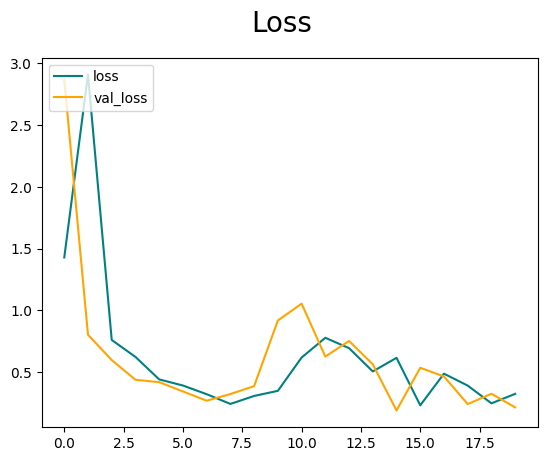

In [298]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.savefig("loss_plot.png")
mlflow.log_artifact("loss_plot.png")

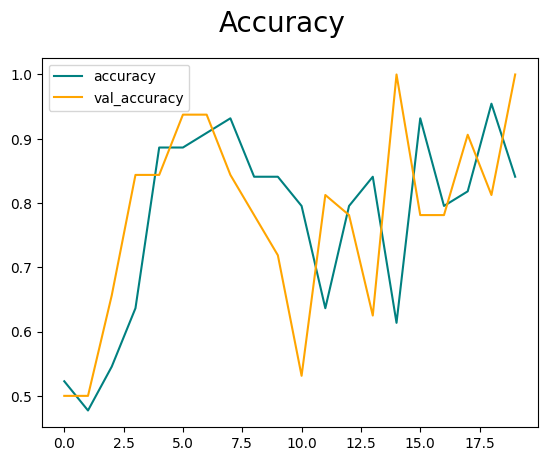

In [299]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.savefig("accuracy_plot.png")
mlflow.log_artifact("accuracy_plot.png")

# 7. Evaluate

In [300]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [301]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [302]:
for batch in test_dataset:
    X, y = batch
    yhat = model.predict(X)
    
    # Convert predictions to binary class labels (0 or 1) if needed
    yhat = tf.cast(yhat > 0.5, dtype=tf.float32)
    
    # Update the metrics
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [303]:
mlflow.log_metrics({
    "precision": pre.result().numpy(),
    "recall": re.result().numpy(),
    "accuracy": acc.result().numpy()
})

# 8. Test

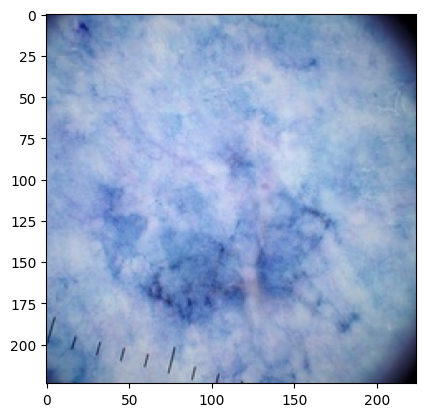

In [304]:
img = cv2.imread('cancer_1.jpg')
plt.imshow(img)
plt.show()

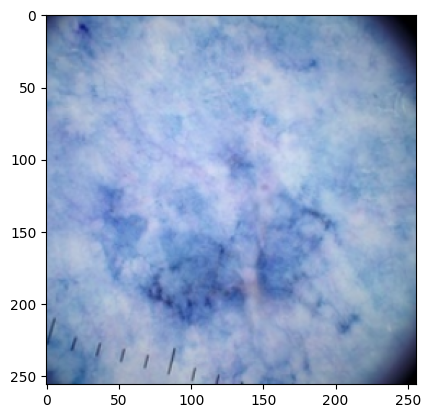

In [305]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()


In [306]:
yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = "non-cancer" if yhat > 0.5 else "cancer"
mlflow.log_param("predicted_class", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


'cancer'

# 9. Save the Model

In [307]:
mlflow.end_run()

In [308]:
with mlflow.start_run() as run:
    # Save model to a temporary path
    model_path = 'models/imageclassifier.h5'
    model.save(model_path)
    
    # Log the model with MLflow
    mlflow.keras.log_model(model, "model")
    mlflow.log_artifact(model_path)
    
    
    
    

    num_train_samples = len(list(train_dataset.unbatch()))
    num_test_samples = len(list(test_dataset.unbatch()))

    # Log dataset parameters
    mlflow.log_param("num_train_samples", num_train_samples)
    mlflow.log_param("num_test_samples", num_test_samples)

    # Log model architecture
    mlflow.log_param("model_architecture", model.to_json())
    
    # Get the run ID
    run_id = run.info.run_id
    print(f"Model saved under run ID: {run_id}")


2024/09/18 04:15:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/18 04:15:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved under run ID: 37d750d333dd423d9a42ddad41b60e7c


# Load The Model

In [309]:
# Load the model from MLflow
model_uri = f"runs:/{run_id}/model"
loaded_model = mlflow.keras.load_model(model_uri)

# Prepare the image for prediction
resize = tf.image.resize(img, (256, 256))
resize = resize.numpy().astype(np.float32) / 255.0
resize = np.expand_dims(resize, axis=0)

# Make a prediction
yhat = loaded_model.predict(resize)
predicted_class = "non-cancer" if yhat > 0.5 else "cancer"
print(predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
cancer


In [310]:
import tensorflow as tf
import numpy as np

# Define the local path to the model
model_path = 'models/imageclassifier.h5'

# Load the model from the local path
loaded_model = tf.keras.models.load_model(model_path)

# Prepare the image for prediction
# Assuming img is a pre-loaded image
resize = tf.image.resize(img, (256, 256))
resize = resize.numpy().astype(np.float32) / 255.0
resize = np.expand_dims(resize, axis=0)

# Make a prediction
yhat = loaded_model.predict(resize)
predicted_class = "non-cancer" if yhat > 0.5 else "cancer"
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
cancer


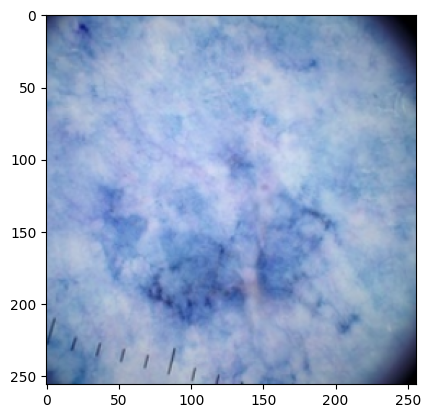

In [311]:
img = cv2.imread('cancer_1.jpg')
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [312]:
resize = tf.image.resize(img, (256, 256))
resize = resize.numpy().astype(np.float32) / 255.0
resize = np.expand_dims(resize, axis=0)

# Make a prediction
yhat = loaded_model.predict(resize)
predicted_class = "non-cancer" if yhat > 0.5 else "cancer"
print(predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
cancer
